# 2 - Calculate Nino 3.4 time series for ACCESS-1.3

In this exercise you will calculate the Nino 3.4 index for the ACCESS-1.3 CMIP5 submission using the sea surafce temperature from the ocean model component

Definition of the Nino 3.4 index from https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni

> Niño 3.4 (5N-5S, 170W-120W):  The  Niño 3.4 anomalies may be thought of as representing the average equatorial SSTs across the Pacific from about the dateline to the South American coast.  The Niño 3.4 index typically uses a 5-month running mean, and El Niño or La  Niña events are defined when the  Niño 3.4 SSTs exceed +/- 0.4C for a period of six months or more.

> Nino X Index computation: (a) Compute area averaged total SST from Niño X region; (b) Compute monthly climatology (e.g., 1950-1979) for area averaged total SST from Niño X region, and subtract climatology from area averaged total SST time series to obtain anomalies; (c) Smooth the anomalies with a 5-month running mean; (d) Normalize the smoothed values by its standard deviation over the climatological period.

The URL for the relevant dataset is 

http://dapds00.nci.org.au/thredds/dodsC/rr3/CMIP5/output1/CSIRO-BOM/ACCESS1-3/historical/mon/ocean/Omon/r1i1p1/latest/tos/tos_Omon_ACCESS1-3_historical_r1i1p1_185001-200512.nc

First step is to open the dataset (remember to import any packages you will need)

In [2]:
import xarray, matplotlib.pyplot as plt
import numpy as np

In [3]:
%matplotlib inline

In [4]:
url = 'http://dapds00.nci.org.au/thredds/dodsC/rr3/CMIP5/output1/CSIRO-BOM/ACCESS1-3/historical/mon/ocean/Omon/r1i1p1/latest/tos/tos_Omon_ACCESS1-3_historical_r1i1p1_185001-200512.nc'                
ds = xarray.open_dataset(url)

Find the sea surface temperature (SST) variable name and create a new variable which selects out all data after 1950. Probably a good idea to plot the first time slice as a reference

In [5]:
tos = ds.tos.sel(time=slice('1950',None))
tos

<xarray.DataArray 'tos' (time: 672, j: 300, i: 360)>
[72576000 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1950-01-16T12:00:00 ... 2005-12-16T12:00:00
  * j        (j) int32 0 1 2 3 4 5 6 7 8 ... 291 292 293 294 295 296 297 298 299
  * i        (i) int32 0 1 2 3 4 5 6 7 8 ... 351 352 353 354 355 356 357 358 359
    lat      (j, i) float32 ...
    lon      (j, i) float32 ...
Attributes:
    standard_name:     sea_surface_temperature
    long_name:         Sea Surface Temperature
    comment:           "this may differ from ""surface temperature"" in regio...
    units:             K
    cell_methods:      time: mean
    cell_measures:     area: areacello
    history:           2012-02-06T01:20:16Z altered by CMOR: replaced missing...
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...

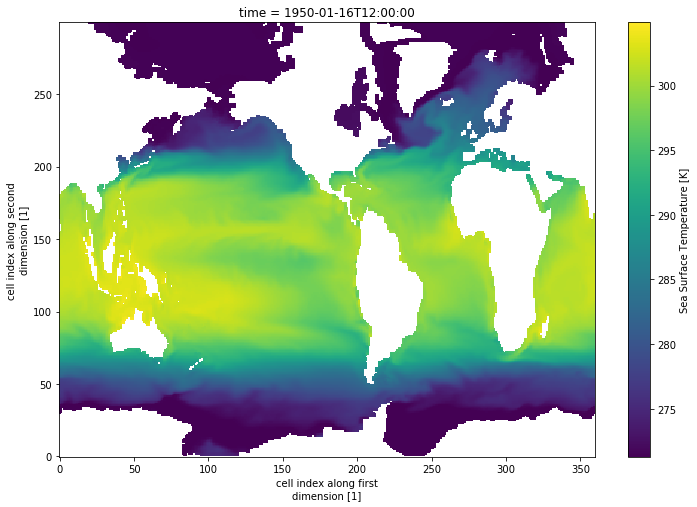

In [6]:
tos.isel(time=0).plot(size=8)

MOM5 is the ocean model component of ACCESS-1.3. In this configuration the ocean has a tripolar grid. This means there are three poles, to avoid having a convergent point in the ocean. All three poles are over land points where there are no wet cells. One pole in the south over Antarctica and two in the north. What this means is that the data have coordinates `i` and `j` and the `lat` and `lon` data variables are 2D and also have coordinates `i` and `j`. The tripolar grid only starts diverging from a normal grid above 60N, so does not affect the calculation of Nino 3.4, but it does make it more difficult to select out the area of interest.

![Tripole Grid](tripole.png)

There are a few ways selecting out the region of interest (ROI). 

1. Find the cell indices for the ROI and use `sel`
2. Chop off the tripole part of the grid and add new 1D lat/lon coordinates to the dataset/variable
3. Use `where` and select for all values within the bounds of interest.

It is the last option that is easiest, for variable `var` it is formulated like so

`var.where((var.lat<5) & (var.lat>-5) & (var.lon>190) & (var.lon<240),drop=True)`

note the `drop=True` option, which will remove all masked cells, which in this case is equivalent to a `sel` operation usin `slice` on `lat` and `lon`

In [7]:
tos_nino34 = tos.where((tos.lat<5) & (tos.lat>-5) & (tos.lon>190) & (tos.lon<240), drop=True)

In [8]:
tos_nino34

<xarray.DataArray 'tos' (time: 672, j: 30, i: 50)>
array([[[300.94846, 300.88568, ..., 297.60992, 297.57465],
        [300.62796, 300.58807, ..., 297.4986 , 297.47824],
        ...,
        [299.68683, 299.54962, ..., 301.09686, 301.13242],
        [300.4037 , 300.18784, ..., 301.11496, 301.1423 ]],

       [[300.71313, 300.59174, ..., 298.63116, 298.65945],
        [300.49048, 300.41953, ..., 298.61975, 298.65106],
        ...,
        [299.50064, 299.48386, ..., 300.90625, 300.95218],
        [299.88474, 299.7831 , ..., 300.94666, 300.9566 ]],

       ...,

       [[302.79315, 302.81284, ..., 298.5471 , 298.43106],
        [302.6761 , 302.67557, ..., 298.36536, 298.26703],
        ...,
        [302.6383 , 302.61084, ..., 301.62723, 301.63782],
        [302.8222 , 302.80893, ..., 301.8747 , 301.88324]],

       [[302.58627, 302.5506 , ..., 298.61194, 298.5167 ],
        [302.33844, 302.2614 , ..., 298.43848, 298.3609 ],
        ...,
        [301.98654, 301.98233, ..., 301.89926, 301.8

In [9]:
print('Check we have the correct spatial extent')
print('Latitude range: {:.1f} - {:.1f}'.format(tos_nino34.lat.min().values, tos_nino34.lat.max().values))
print('Longitude range: {:.1f} - {:.1f}'.format(tos_nino34.lon.min().values, tos_nino34.lon.max().values))

Check we have the correct spatial extent
Latitude range: -4.8 - 4.8
Longitude range: 190.5 - 239.5


Calculate a monthly climatology of mean SST for the 1950-1979 period. Note this should be a single value for each month

In [10]:
tos_nino34_climatology = tos_nino34.sel(time=slice('1950','1979')).groupby('time.month').mean()

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/groupby.py:639: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)


Compare the values of climatological mean SST with those from the [classic Trenberth paper](https://doi.org/10.1175/1520-0477(1997)078%3C2771:TDOENO%3E2.0.CO;2)

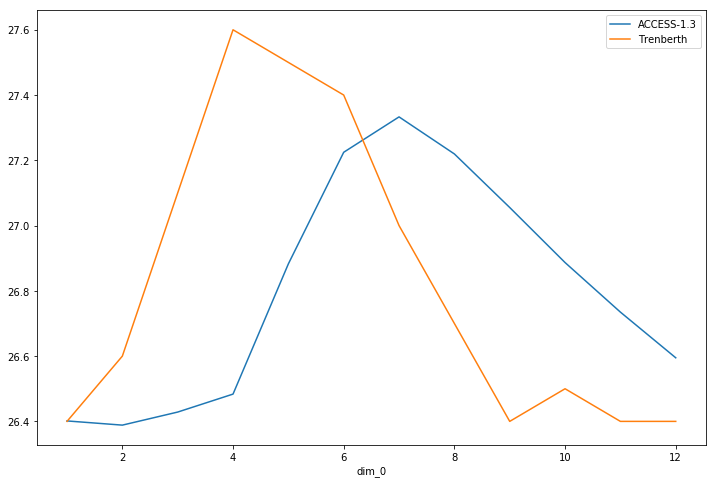

In [11]:
(tos_nino34_climatology - 273).plot(size=8,label='ACCESS-1.3')
mean_sst_trenberth = xarray.DataArray([26.4, 26.6, 27.1, 27.6, 27.5, 27.4, 27.0, 26.7, 26.4, 26.5, 26.4, 26.4], coords=[np.arange(12)+1])
mean_sst_trenberth.plot(label="Trenberth")
plt.legend()

Now calculate the Nino 3.4 index, by subtracting the monthly climatology from the original SST data and take the mean over the spatial coordinates

In [12]:
index_nino34 = (tos_nino34.groupby('time.month')-tos_nino34_climatology).mean(dim=['j','i'])

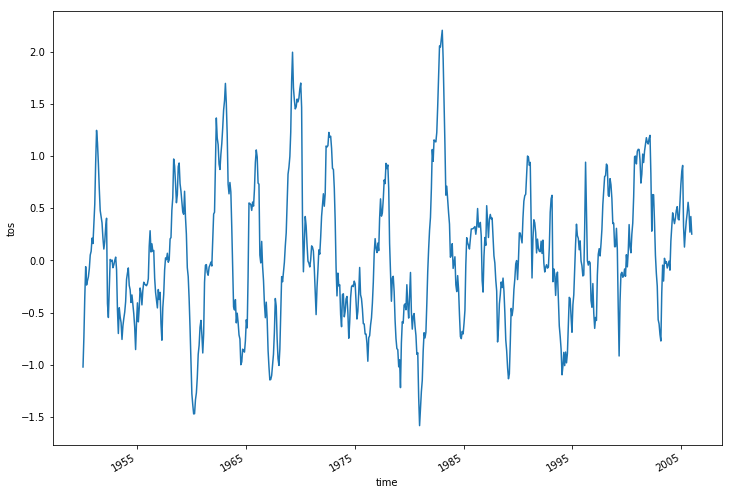

In [13]:
index_nino34.plot(size=8)

Next step is to apply a 5 month moving average smoother. xarray has a method [rolling](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.rolling.html) which can be applied to the your saved variable and then directly plotted

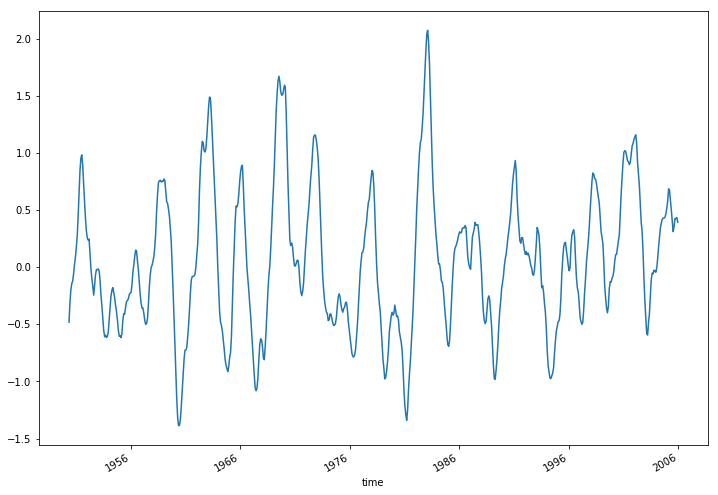

In [14]:
index_nino34.rolling(time=5).mean().plot(size=8)

Last step is to normalise by the standard deviation. Calculate the standard deviation of the SST data in the Nino 3.4 area for the climatological period. xarray provides the [std](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.std.html?highlight=std) operator for this purpose. Save the result in a new variable. Note that this is an average over the entire climatological period, so should be a single value

In [15]:
tas_nino34_climatology_std = tos_nino34.sel(time=slice('1950-01','1979-12')).std()

As the standard deviation is a single value it is sufficient to use the same formulation for your plot as above, but divide by the standard deviation and then plot the result. Note that parentheses will be required around the divide operation to correctly chain the `plot()` operator. e.g. something like

`(index_variable.rolling().mean() / std_dev).plot()`

Alternatively you could save the normalised value into a new variable and then plot that

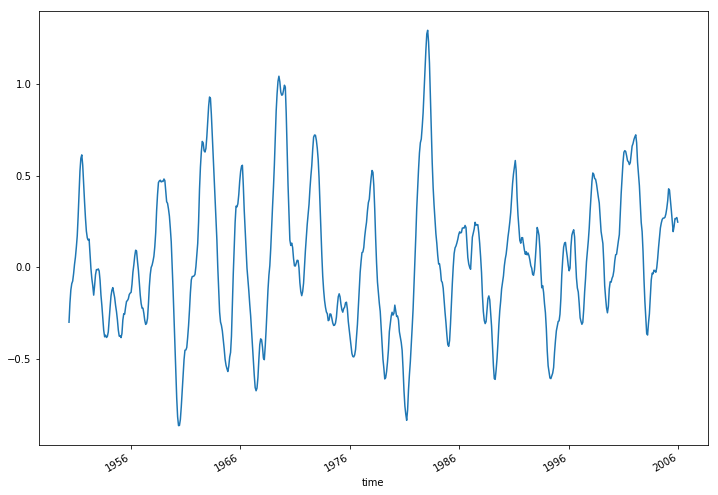

In [16]:
(index_nino34.rolling(time=5).mean() / tas_nino34_climatology_std).plot(size=8)

Add some -0.4/+0.4 lines which are the El Niño threshold

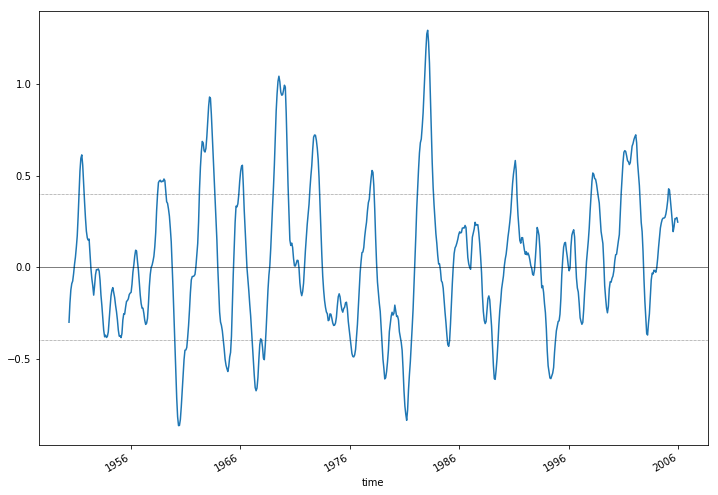

In [17]:
(index_nino34.rolling(time=5).mean() / tas_nino34_climatology_std).plot(size=8)
plt.axhline(0,color='black',lw=0.5)
plt.axhline(0.4,color='black',linewidth=0.5,linestyle='dotted')
plt.axhline(-0.4,color='black',linewidth=0.5,linestyle='dotted')

As an extension, we will re-create the figure from Trenberth

![Tripole Grid](Trenberth.png)

Assign the final Nino 3.4 normalised and smoothed index to a temporary variable for convenience

In [18]:
tmp = (index_nino34.rolling(time=5).mean() / tas_nino34_climatology_std)

To recreate the Nino 3.4 plot from Trenberth requires using the matplotlib function [fill_between](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.fill_between.html) directly. It is called twice, once for the El Nino events, and then again for La Nina. Masking is used to select only values above, or below, a certain threshold, and the same threshold is then used as an argument to `fill_between` to set the other limit of the fill colour.

Text(0.5,1,'Nino 3.4 Region (Threshold = 0.4 $\\degree$C)')

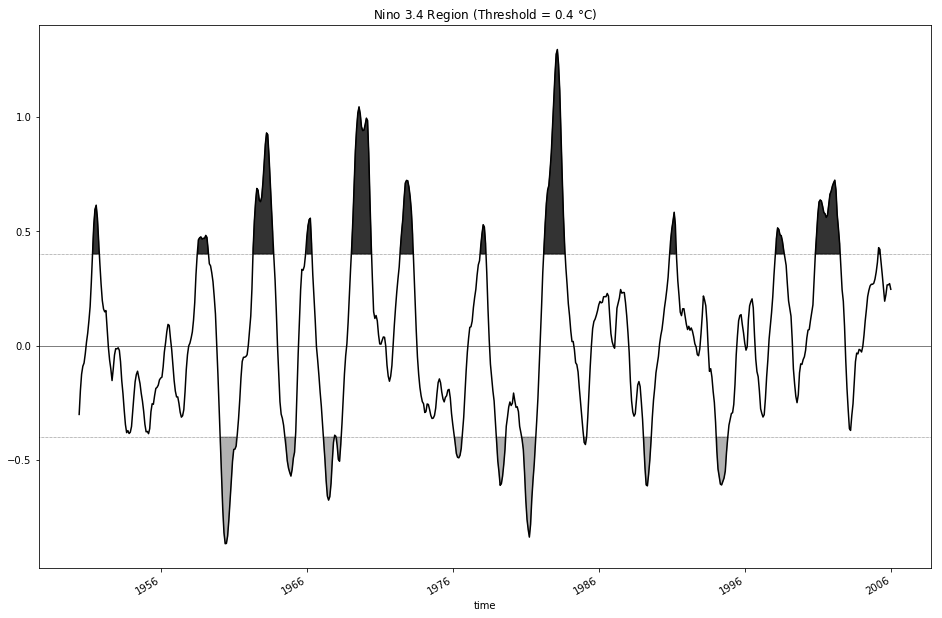

In [19]:
fig = plt.figure(figsize=(16, 10))
plt.fill_between(tmp.time.values, tmp.where(tmp>=0.4).values, 0.4, color='black', alpha=0.8)
plt.fill_between(tmp.time.values, tmp.where(tmp<=-0.4).values, -0.4, color='black', alpha=0.3)
# plt.fill_between(tmp.time.values, tmp.where(tmp<0.4,0.4).where(tmp>-0.4,-0.4).values, color='white')
tmp.plot(color='black')
plt.axhline(0,color='black',lw=0.5)
plt.axhline(0.4,color='black',linewidth=0.5,linestyle='dotted')
plt.axhline(-0.4,color='black',linewidth=0.5,linestyle='dotted')
plt.title('Nino 3.4 Region (Threshold = 0.4 $\degree$C)')

Also from the Trenberth paper

> With these quantitative assignments of events, it is readily seen that there are 177 out of 567 months (January 1950-March 1997) assigned as El Nino (31%) and 133 months assigned as La Nina months (23%). 

In [20]:
"Percentage of El Nino events = {:0.1f}%".format(100 * (tmp.where(tmp>=0.4).count() / tmp.count()).values)

'Percentage of El Nino events = 18.4%'

In [21]:
"Percentage of La Nina events = {:0.1f}%".format(100 * (tmp.where(tmp<=-0.4).count() / tmp.count()).values)

'Percentage of La Nina events = 12.1%'